In [8]:
from src.bertopic_supervised import data_loading, predict_df
from src.utils import get_mapping
from src.evaluation import compute_all_metrics, plot_topic_metric_per_model, plot_metrics_per_model
import joblib
from pathlib import Path
from sklearn.preprocessing import MultiLabelBinarizer
from loguru import logger
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.multiclass import OneVsRestClassifier

In [9]:
MODEL_DIR = Path("models/cat_boost_models")
DATA_DIR = Path("data/blogs_articles")

model_data = {}
embedding_models = [
        'text-embedding-3-large', 
        'all-MiniLM-L12-v2', 
        'all-mpnet-base-v2']

needed_columns = ["id", "topic_label", "chunks", "chunks_embeddings"]

for model_name in embedding_models:
    # Loading Model and Data
    model_data[model_name] = joblib.load(MODEL_DIR / f"cat_boost_{model_name}.joblib")
    temp_test = data_loading(DATA_DIR / f"sv_embeddings_{model_name}.parquet")[2][needed_columns]
    test_df_pred = predict_df(temp_test, model_data[model_name]['clf'], model_data[model_name]['thr'], agg = 'max')
    model_data[model_name]['test_df_pred'] = test_df_pred

    overall_metrics = compute_all_metrics(test_df_pred['topic_label'].to_list(), test_df_pred['predicted_labels'].to_list(), label_to_id=get_mapping(id_to_label=True))
    per_label_table = overall_metrics.pop('per_label_table')
    model_data[model_name]['overall_metrics'] = overall_metrics
    model_data[model_name]['per_label_table'] = per_label_table

2025-09-13 13:53:13.075 | INFO     | src.bertopic_supervised:data_loading:26 - Loading embedding dataset from data/blogs_articles/sv_embeddings_text-embedding-3-large.parquet
2025-09-13 13:53:13.627 | INFO     | src.bertopic_supervised:predict_df:202 - Start prediction.
Predicting docs: 100%|██████████| 525/525 [04:51<00:00,  1.80it/s]
c:\Users\povhi\OneDrive\01_Uni\03_TU Wien\MSc Data Science\09_Interdisciplinary_Project\ECB_Topic_Chronicles\src\evaluation.py:209: RuntimeWarning: invalid value encountered in divide
  2 * precision * recall / (precision + recall),
c:\Users\povhi\OneDrive\01_Uni\03_TU Wien\MSc Data Science\09_Interdisciplinary_Project\ECB_Topic_Chronicles\src\evaluation.py:250: RuntimeWarning: invalid value encountered in divide
  2 * precision * recall / (precision + recall),
2025-09-13 13:58:05.155 | INFO     | src.bertopic_supervised:data_loading:26 - Loading embedding dataset from data/blogs_articles/sv_embeddings_all-MiniLM-L12-v2.parquet
2025-09-13 13:58:06.142 | 

In [10]:
res_dfs = {k:v['test_df_pred'] for k,v in model_data.items()}
metr_dfs = {k:pl.DataFrame(v['per_label_table']) for k,v in model_data.items()}
# metr_dfs = {}
# for k,v in _.items(): 
#     temp_v = v.with_columns([
#         pl.col("label_id").map_elements(lambda x: get_mapping(label_to_id=True).get(x)).alias("label_name")])

#     metr_dfs[k] = temp_v

for k,v in metr_dfs.items(): 
    v.write_csv(MODEL_DIR/f"topic_metrics_{k}.csv")

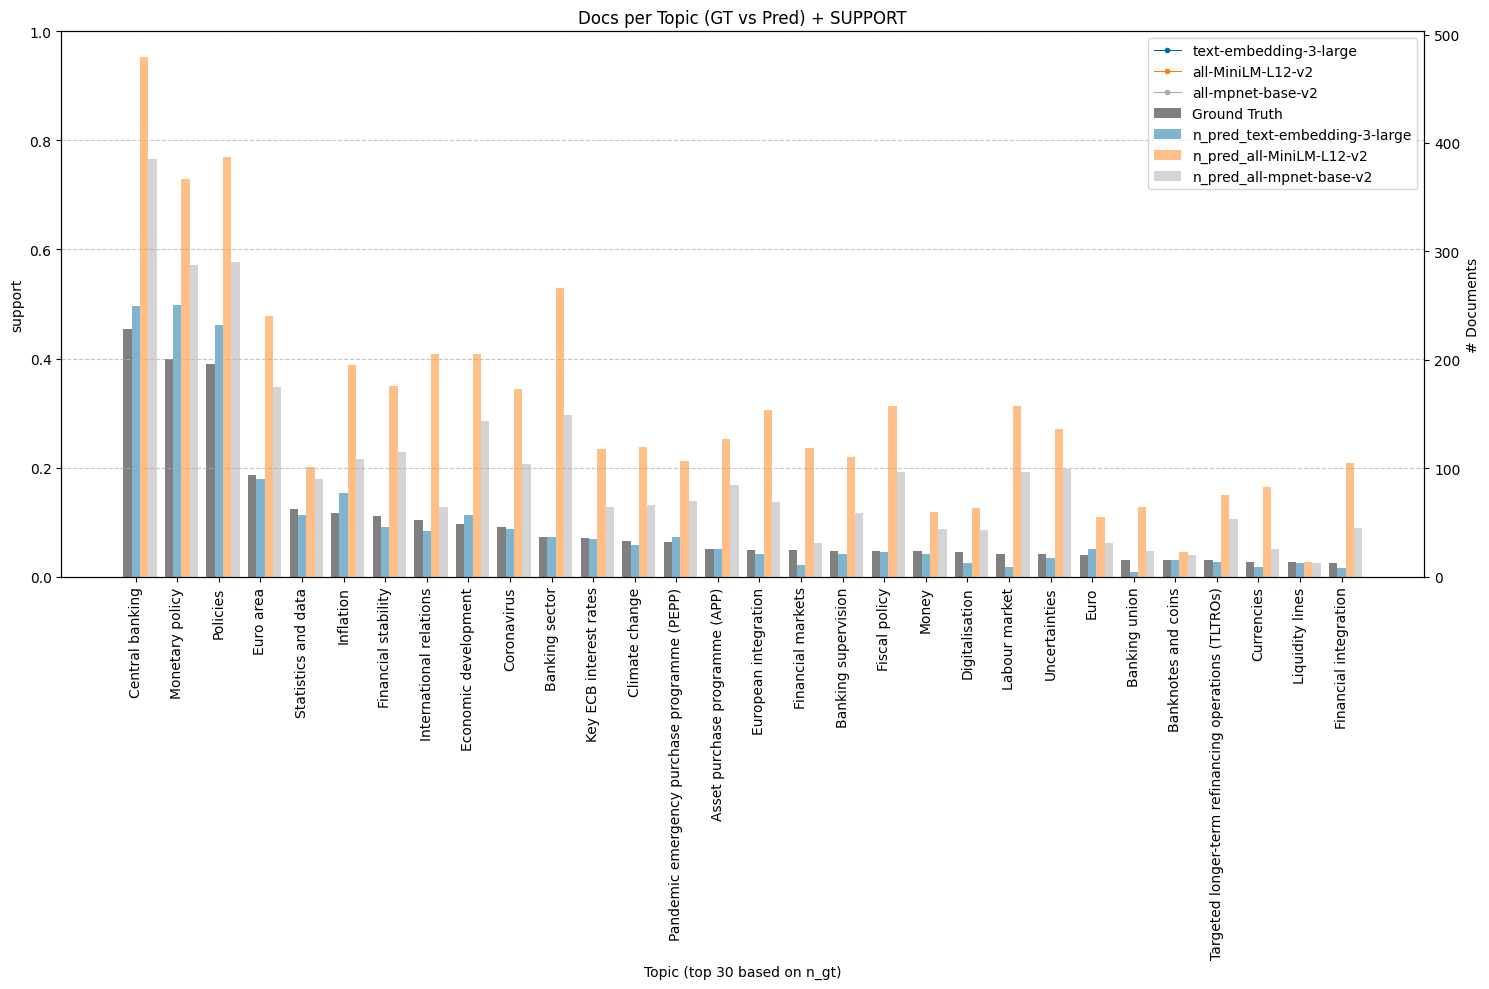

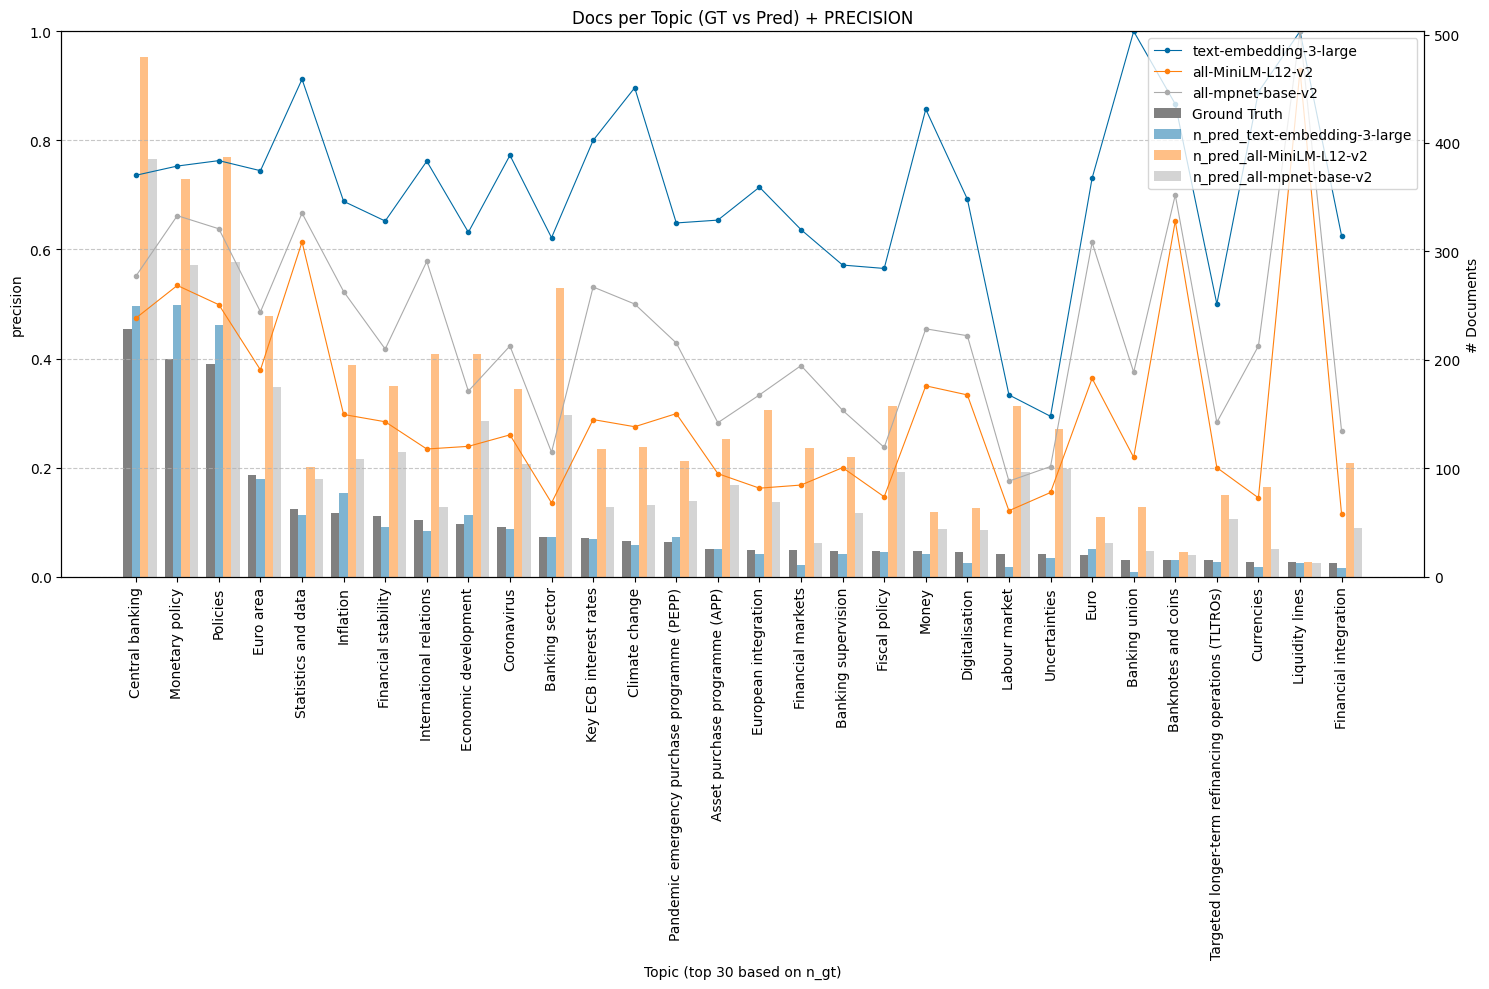

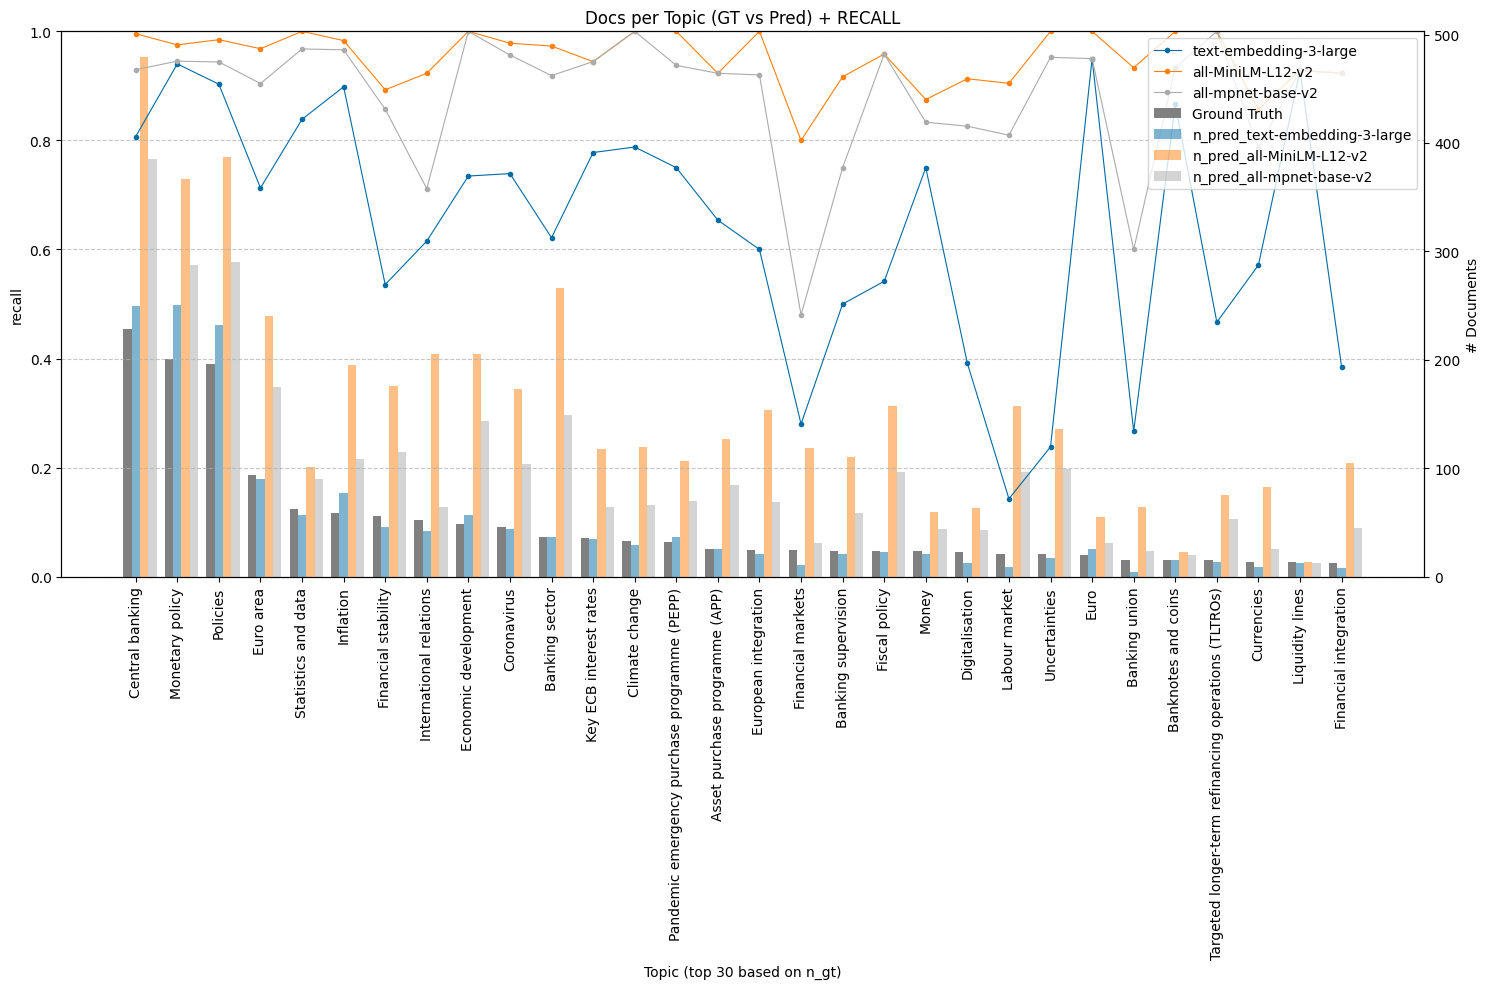

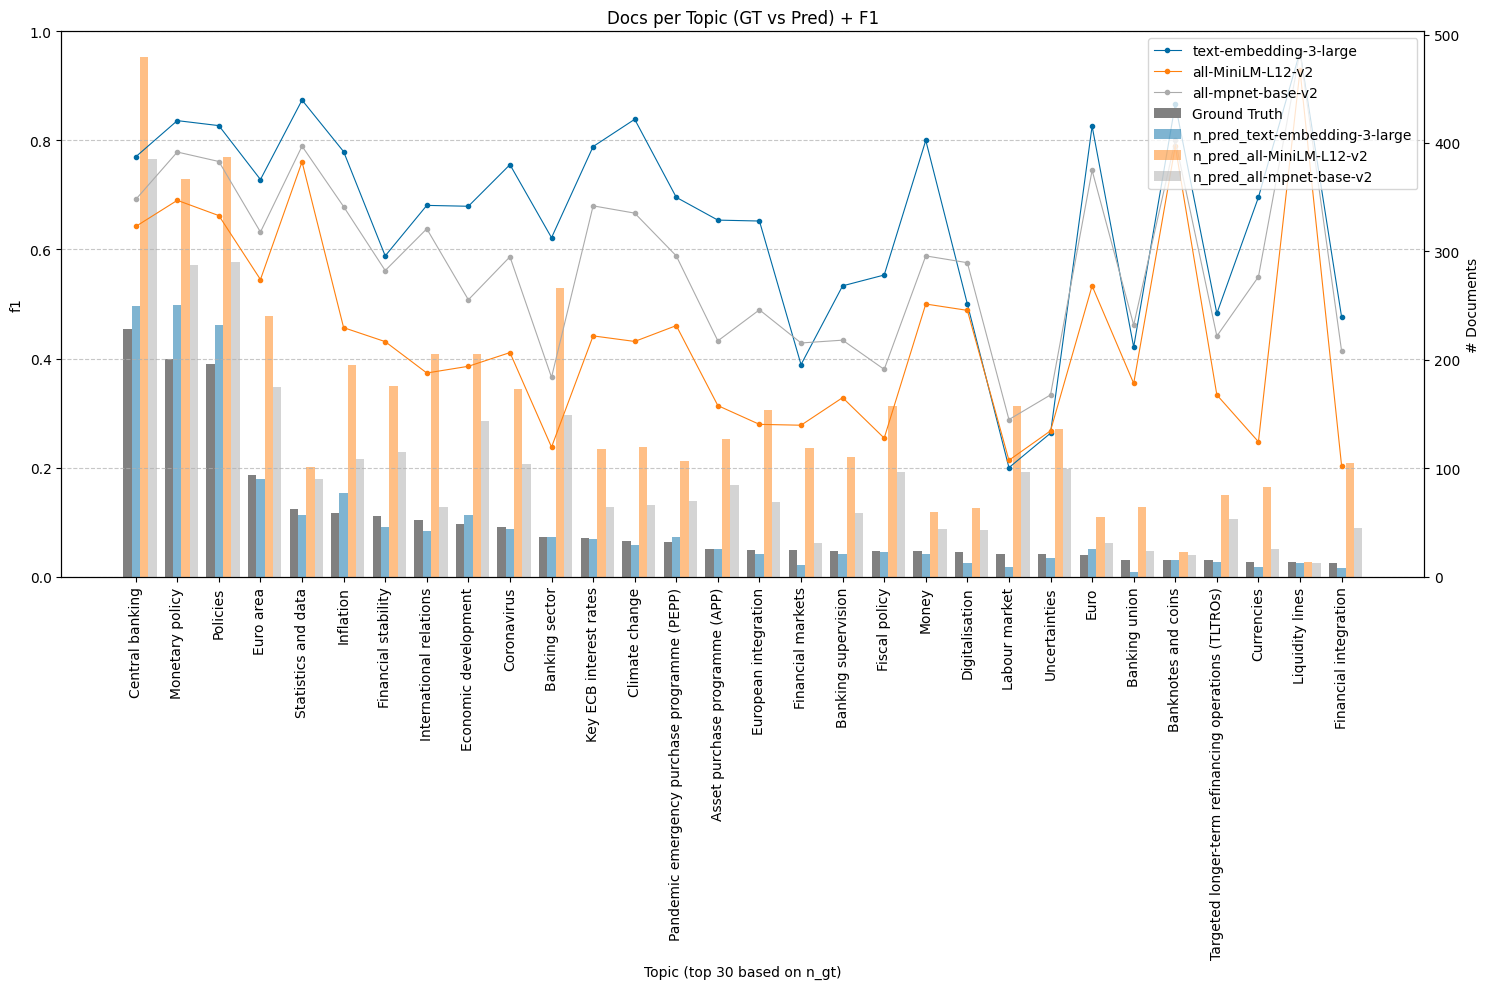

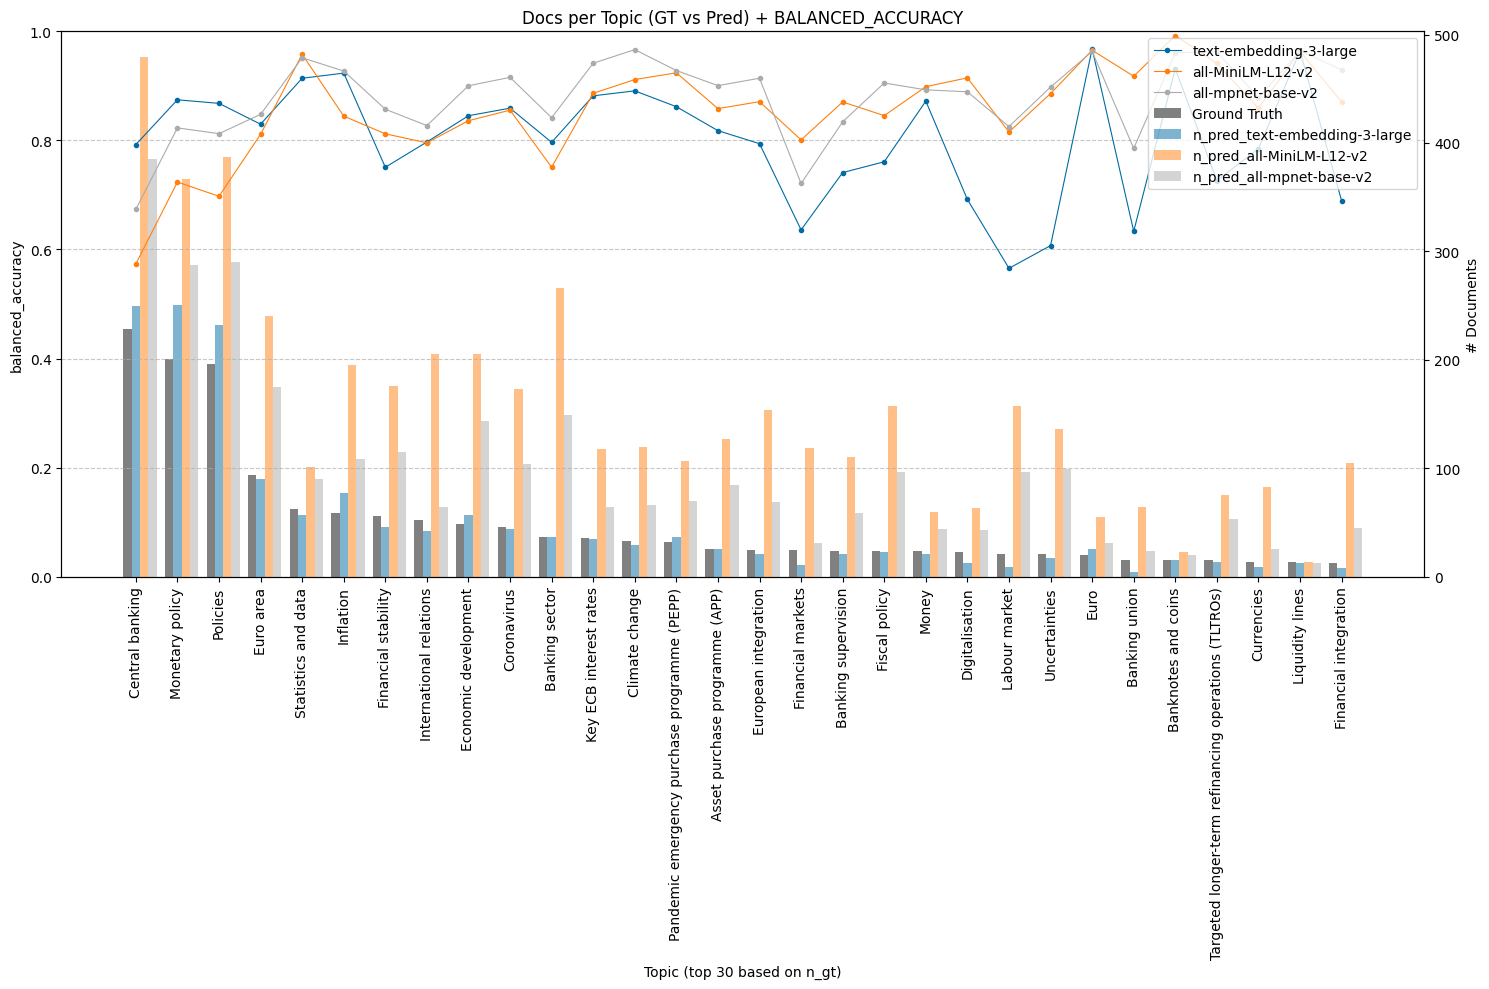

In [11]:
for m in ['support', 'precision', 'recall', 'f1', 'balanced_accuracy']:
    plot_topic_metric_per_model(res_dfs, metr_dfs, metric = m, top_k = 30, save = MODEL_DIR / f"per_topic_{m}_all_models.png")

In [12]:
metrics_all = {}
metrics_all['metric'] = list(sorted(model_data['text-embedding-3-large']['overall_metrics'].keys()))
for k,v in model_data.items(): 
    temp_dict = dict(sorted(v['overall_metrics'].items()))
    metrics_all[k] = list(temp_dict.values())
metrics_all_df = pl.DataFrame(metrics_all)

metrics_all_df.write_csv(MODEL_DIR / 'all_metrics_per_model.csv')

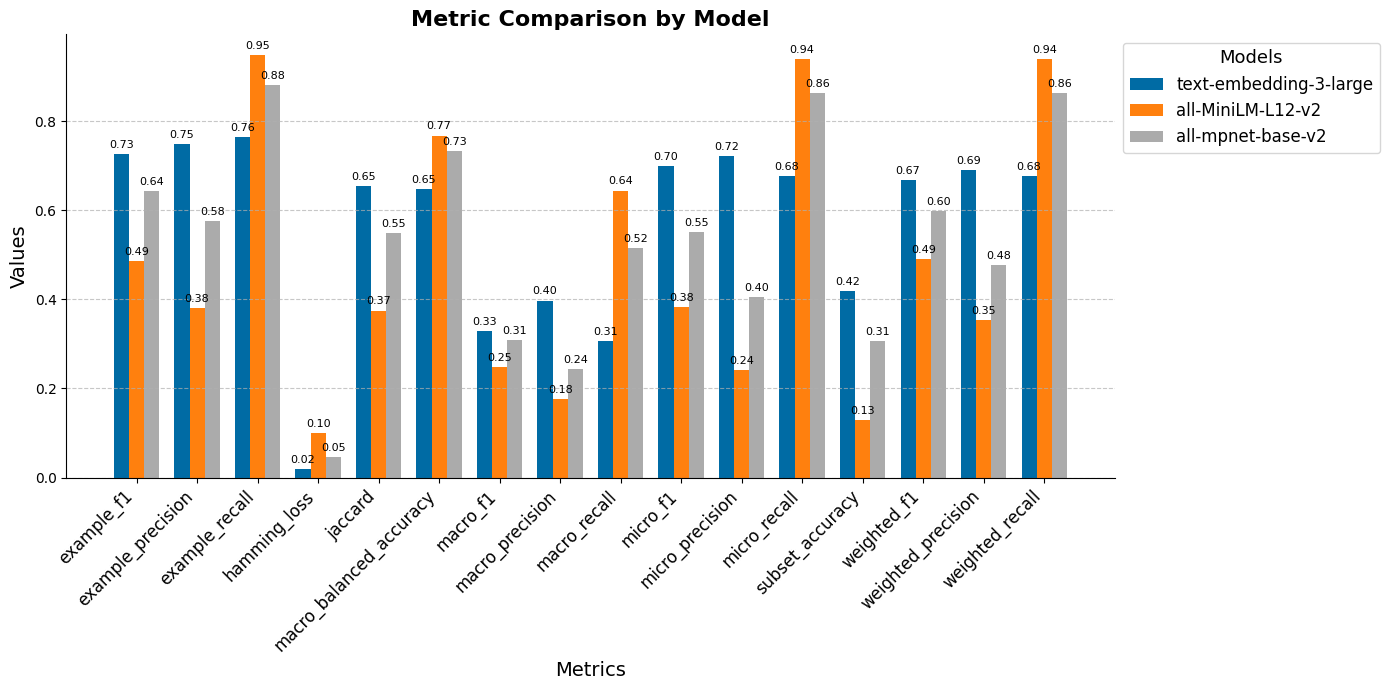

In [13]:
plot_metrics_per_model(metrics_all_df, save = MODEL_DIR / 'all_metrics_per_model.png')